### Analysis for token transaction

- amount distribution
- count of EOA
- use per EOA
- in/out ratio

Reference

- `web3.eth.get_code('0x6C8f2A135f6ed072DE4503Bd7C4999a1a17F824B')` => return `0x` if EOA

In [3]:
from credmark.cmf.ipython import create_cmf
from credmark.cmf.types import (Address, BlockNumber, Contract, Token, Portfolio, PriceWithQuote)
from credmark.cmf.types.data.fiat_currency_data import FIAT_CURRENCY_DATA_BY_SYMBOL
from credmark.cmf.model.errors import ModelRunError, ModelDataError
from web3 import HTTPProvider, Web3
from datetime import datetime, timezone, timedelta

cmf_param = {
                'block_number': None,
                'chain_to_provider_url': {'1': 'http://192.168.68.122:8545'},
                'api_url': 'http://192.168.68.122:8700',
                'use_local_models': '*', # use local to speed up
            }

# When using fill_db_evt in a loop, create cmf context outside the loop and sent _cmf_param = None
# When using fill_db_evt standalone, either 1) create cmf context outside the loop and sent _cmf_param = None, 2) sent in non-None cmf_param.
context, _model_loader = create_cmf(cmf_param)
context._web3 = Web3(HTTPProvider(context.web3.provider.endpoint_uri, request_kwargs={'timeout': 3600 * 10}))
context._web3.eth.default_block = int(context.block_number)
end_block = int(context.block_number)

In [4]:
token_crv = Token('CRV')
token_ve_crv = Token('0x5f3b5DfEb7B28CDbD7FAba78963EE202a494e2A2')
token_cvx_crv = Token('0x62B9c7356A2Dc64a1969e19C23e4f579F9810Aa7')
token_cmk = Token('CMK')
token_s1 = Token('0x471c3A7f132bc94938516CB2Bf6f02C7521D2797')
token_s2 = Token('0x208A9C9D8E1d33a4f5b371Bf1864AA125379Ba1B')
token_uni = Token('UNI')
token_link = Token('LINK')
token_wbtc = Token('WBTC')
token_weth = Token('WETH')

token_crv,token_ve_crv,token_cvx_crv,token_cmk,token_uni,token_link

(Token(address='0xd533a949740bb3306d119cc777fa900ba034cd52'),
 Token(address='0x5f3b5dfeb7b28cdbd7faba78963ee202a494e2a2'),
 Token(address='0x62b9c7356a2dc64a1969e19c23e4f579f9810aa7'),
 Token(address='0x68cfb82eacb9f198d508b514d898a403c449533e'),
 Token(address='0x1f9840a85d5af5bf1d1762f925bdaddc4201f984'),
 Token(address='0x514910771af9ca656af840dff83e8264ecf986ca'))

In [14]:
current_block = int(context.block_number)
one_day_earlier_block = context.block_number.from_timestamp(context.block_number.timestamp_datetime - timedelta(days=1))
(current_block - one_day_earlier_block, current_block, one_day_earlier_block)

(7159, 16534420, 16527261)

In [27]:
p1 = BlockNumber(15680216).timestamp_datetime - BlockNumber(15667775).timestamp_datetime
print(f'{p1.days}d{p1.seconds / 3600:.1f}h')

p2 = BlockNumber(14884786).timestamp_datetime - BlockNumber(14858859).timestamp_datetime
print(f'{p2.days}d{p2.seconds / 3600:.1f}h')

1d17.8h
4d5.5h


In [10]:
def fetch_tx_block_range(_token):
    with context.ledger.TokenTransfer as q:
        df_tx = (q.select(
            columns=[],
            aggregates=[(q.BLOCK_NUMBER.max_(), 'max_block_number'), (q.BLOCK_NUMBER.min_(), 'min_block_number')],
            where=q.TOKEN_ADDRESS.eq(_token.address),
            order_by=q.BLOCK_NUMBER.desc()
            ).to_dataframe())
    return df_tx

display(fetch_tx_block_range(token_s1))
display(fetch_tx_block_range(token_s2))
display(fetch_tx_block_range(token_weth))


,max_block_number,min_block_number
0,14884786,14858859


,max_block_number,min_block_number
0,15680216,15667775


,max_block_number,min_block_number
0,16534420,4753506


In [11]:
def fetch_tx_token(_token, _from_block):
    with context.ledger.TokenTransfer as q:
        df_tx = (q.select(
            columns=q.columns,
            where=q.TOKEN_ADDRESS.eq(_token.address).and_(q.BLOCK_NUMBER.gt(_from_block)),
            order_by=q.BLOCK_NUMBER.desc()
            )
            .to_dataframe()
            .assign(value = lambda x: x.value / 10**_token.decimals if 'value' in x else 0))
    return df_tx

df_crv = fetch_tx_token(token_crv, one_day_earlier_block)
df_ve_crv = fetch_tx_token(token_ve_crv, one_day_earlier_block)
df_cvx_crv = fetch_tx_token(token_cvx_crv, one_day_earlier_block)
df_uni = fetch_tx_token(token_uni, one_day_earlier_block)
df_link = fetch_tx_token(token_link, one_day_earlier_block)
df_cmk = fetch_tx_token(token_cmk, one_day_earlier_block)
df_s1 = fetch_tx_token(token_s1, 0)
df_s2 = fetch_tx_token(token_s2, 0)
df_weth = fetch_tx_token(token_weth, 0)
df_wbtc = fetch_tx_token(token_wbtc, 0)

,block_hash,block_number,block_timestamp,from_address,log_index,token_address,to_address,transaction_hash,value
0,0x55c5dc47d655ad0b9f275d7df0c1619f199492976b9a...,16534413,1675259915,0x0000000000000000000000000000000000000000,128,0xd533a949740bb3306d119cc777fa900ba034cd52,0x989aeb4d175e16225e39e87d0d97a3360524ad80,0x1f065ad9f66cbfb110f49a4cd6b67b03d88b8026d41d...,2036.656976
1,0x55c5dc47d655ad0b9f275d7df0c1619f199492976b9a...,16534413,1675259915,0xf403c135812408bfbe8713b5a23a04b3d48aae31,117,0xd533a949740bb3306d119cc777fa900ba034cd52,0xcf50b810e57ac33b91dcf525c6ddd9881b139332,0x1f065ad9f66cbfb110f49a4cd6b67b03d88b8026d41d...,103.583432
2,0x55c5dc47d655ad0b9f275d7df0c1619f199492976b9a...,16534413,1675259915,0xf403c135812408bfbe8713b5a23a04b3d48aae31,141,0xd533a949740bb3306d119cc777fa900ba034cd52,0xa8f93c696888b6b7d2a6aac22e484c5155694fb0,0x1f065ad9f66cbfb110f49a4cd6b67b03d88b8026d41d...,8.927911
3,0x55c5dc47d655ad0b9f275d7df0c1619f199492976b9a...,16534413,1675259915,0xf403c135812408bfbe8713b5a23a04b3d48aae31,122,0xd533a949740bb3306d119cc777fa900ba034cd52,0x1389388d01708118b497f59521f6943be2541bb7,0x1f065ad9f66cbfb110f49a4cd6b67b03d88b8026d41d...,41.91578
4,0x55c5dc47d655ad0b9f275d7df0c1619f199492976b9a...,16534413,1675259915,0x989aeb4d175e16225e39e87d0d97a3360524ad80,139,0xd533a949740bb3306d119cc777fa900ba034cd52,0xf403c135812408bfbe8713b5a23a04b3d48aae31,0x1f065ad9f66cbfb110f49a4cd6b67b03d88b8026d41d...,1785.58213
...,...,...,...,...,...,...,...,...,...
3674,0xec22fa937296c938cc06219c59738525791b0aecc39a...,16527294,1675173995,0x0392321e86f42c2f94fbb0c6853052487db521f0,239,0xd533a949740bb3306d119cc777fa900ba034cd52,0x6db65261a4fc3f88e60b7470e9b38db0b22e785c,0xbd107fa0685271205bb8d9118bdf8d9d170d9f3d0bb5...,6833.475302
3675,0x6d8defa9749db60ee06dd4dfa3958f8da0d35a95ecbf...,16527287,1675173911,0x3fe65692bfcd0e6cf84cb1e7d24108e434a7587e,236,0xd533a949740bb3306d119cc777fa900ba034cd52,0xaa0c3f5f7dfd688c6e646f66cd2a6b66acdbe434,0xf6e596cce594e5287b3d73933c4f08297d5f50b30a8c...,677.353075
3676,0x7b17dbc8cfe733ca5d8c6bd1ce2280ed0e33bc7fbbe4...,16527281,1675173839,0xc17ff2a0906b006136d1501d2f13b3cef13af006,39,0xd533a949740bb3306d119cc777fa900ba034cd52,0x6cc5f688a315f3dc28a7781717a9a798a59fda7b,0x7cae54ffc6feb0ffa0b781e1a3ff79adec66738d4db6...,29236.745505
3677,0x95328ceec989ec745de4104a85c2aff4ebc90ad2d40d...,16527273,1675173743,0xd0aa804dde4315da2ed244ea5fb3e1767d5008bc,181,0xd533a949740bb3306d119cc777fa900ba034cd52,0x8014595f2ab54cd7c604b00e9fb932176fdc86ae,0xa9dd0eb7bc60d95fe4fec53f0ccfd8511ed1e53e73a6...,43.925776


,value


,block_hash,block_number,block_timestamp,from_address,log_index,token_address,to_address,transaction_hash,value
0,0xb8e92c2ed045057b48e19a73bd670d7a838d9e3159b4...,16534377,1675259483,0xaa0c3f5f7dfd688c6e646f66cd2a6b66acdbe434,572,0x62b9c7356a2dc64a1969e19c23e4f579f9810aa7,0x3fe65692bfcd0e6cf84cb1e7d24108e434a7587e,0xee12510a3e96c0265f208fd1b28d663ac74ea20b5119...,434.630225
1,0xb8e92c2ed045057b48e19a73bd670d7a838d9e3159b4...,16534377,1675259483,0x88ce30f11723e38ffafa91a22462e57222433467,569,0x62b9c7356a2dc64a1969e19c23e4f579f9810aa7,0xaa0c3f5f7dfd688c6e646f66cd2a6b66acdbe434,0xee12510a3e96c0265f208fd1b28d663ac74ea20b5119...,434.630225
2,0xaf7da518c6440a18f1916e496d95b3737da329775f6a...,16534361,1675259291,0x9d0464996170c6b9e75eed71c68b99ddedf279e8,122,0x62b9c7356a2dc64a1969e19c23e4f579f9810aa7,0x88ce30f11723e38ffafa91a22462e57222433467,0x9250a62c20a2e1ca183b12c94b0cdeb9ad6c0a5a801d...,434.630225
3,0xd60960a85169a6e7c41ba9793b7897966a7335370bfc...,16534352,1675259183,0x3fe65692bfcd0e6cf84cb1e7d24108e434a7587e,321,0x62b9c7356a2dc64a1969e19c23e4f579f9810aa7,0x129376ca458092591d05ce549c670519d8d7e68b,0x19be831fdc2b0426df415b62ed5de481aacbc49f7c05...,649.868777
4,0x53c93c0691fe44ff337656468b1373d4a341944239b4...,16534339,1675259027,0x72a19342e8f1838460ebfccef09f6585e32db86e,280,0x62b9c7356a2dc64a1969e19c23e4f579f9810aa7,0x8bb4ffb2a5a7785b003a639e13544b5e9b196508,0x994809945a3cf8a1eb728f2674a4661e67d80ec73f4c...,42.858023
...,...,...,...,...,...,...,...,...,...
574,0x7adecfe2982d314a30795ff2841f34c96da9b6542498...,16527369,1675174907,0x3fe65692bfcd0e6cf84cb1e7d24108e434a7587e,311,0x62b9c7356a2dc64a1969e19c23e4f579f9810aa7,0x4e263b7a7336b986818b3211f89fb8b960fbfd75,0xfc067ebe1aebb6b0f792f8e4e5c4ef12e9f3a1e3e244...,5394.998556
575,0x6d8defa9749db60ee06dd4dfa3958f8da0d35a95ecbf...,16527287,1675173911,0xd0aa804dde4315da2ed244ea5fb3e1767d5008bc,244,0x62b9c7356a2dc64a1969e19c23e4f579f9810aa7,0xaa0c3f5f7dfd688c6e646f66cd2a6b66acdbe434,0xf6e596cce594e5287b3d73933c4f08297d5f50b30a8c...,900.456812
576,0x6d8defa9749db60ee06dd4dfa3958f8da0d35a95ecbf...,16527287,1675173911,0xaa0c3f5f7dfd688c6e646f66cd2a6b66acdbe434,247,0x62b9c7356a2dc64a1969e19c23e4f579f9810aa7,0x3fe65692bfcd0e6cf84cb1e7d24108e434a7587e,0xf6e596cce594e5287b3d73933c4f08297d5f50b30a8c...,900.456812
577,0x95328ceec989ec745de4104a85c2aff4ebc90ad2d40d...,16527273,1675173743,0x0000000000000000000000000000000000000000,182,0x62b9c7356a2dc64a1969e19c23e4f579f9810aa7,0xd0aa804dde4315da2ed244ea5fb3e1767d5008bc,0xa9dd0eb7bc60d95fe4fec53f0ccfd8511ed1e53e73a6...,43.925776


,block_hash,block_number,block_timestamp,from_address,log_index,token_address,to_address,transaction_hash,value
0,0x84dc9665f37845c0d5e439cecb623396f31f8165849e...,16534418,1675259975,0x1e6a793466586d2f181aba13f14d7773f5ab5246,102,0x1f9840a85d5af5bf1d1762f925bdaddc4201f984,0xaf0b0000f0210d0f421f0009c72406703b50506b,0xd2d2425f08034979eab7f9ce193e3f757da9a6643d80...,2.13
1,0xe8e11c789c73ee5fe7022f0809522b2f03a3ea6dbc18...,16534410,1675259879,0xaf0b0000f0210d0f421f0009c72406703b50506b,74,0x1f9840a85d5af5bf1d1762f925bdaddc4201f984,0x0ebdac160966dd487c984c1fd31890e94b3898d8,0xd310c6e2421b90f0a70202ae40f2bfad24cb6d5833cc...,0.151095
2,0x54e9d3d106f9092c0ec4b6fdfff6315d8786ee382e67...,16534406,1675259831,0xd6160773a6aecc0c68d5a9bbbde8ab26a752c0e0,178,0x1f9840a85d5af5bf1d1762f925bdaddc4201f984,0x75e89d5979e4f6fba9f97c104c2f0afb3f1dcb88,0x78b192b3283b79c41b0c108f5c1a4ed159f6934e6294...,236.0603
3,0x4d43acb380ac608c4549c27c9695e43cbb242e1c95dc...,16534403,1675259795,0x28c6c06298d514db089934071355e5743bf21d60,87,0x1f9840a85d5af5bf1d1762f925bdaddc4201f984,0x7887a1a4098097ef85b2146a0fee24f52f91ec42,0x24bc295c9a70e898fe972e3257b96f51483cefe4a285...,2.18723
4,0x8375665650f556736945fa5b02d9cbed6e35f51e2b86...,16534394,1675259687,0xe86a28a3ec6642c0a1d131ae4e3955029a3232db,313,0x1f9840a85d5af5bf1d1762f925bdaddc4201f984,0xd6160773a6aecc0c68d5a9bbbde8ab26a752c0e0,0x0072c4afa6b895cba163e939a57c2d57f86c0bc35aa4...,231.0603
...,...,...,...,...,...,...,...,...,...
1315,0x2cc95e531305832345016ed45da8457ed5537ba75a55...,16527310,1675174187,0x6cc5f688a315f3dc28a7781717a9a798a59fda7b,101,0x1f9840a85d5af5bf1d1762f925bdaddc4201f984,0xf6affff7e3c89786a326aa69cca0f37dcbe187ae,0xc074b626356591c2e98b69c3fcede18e693109e2770e...,3808.967
1316,0x6d8defa9749db60ee06dd4dfa3958f8da0d35a95ecbf...,16527287,1675173911,0xa9d1e08c7793af67e9d92fe308d5697fb81d3e43,133,0x1f9840a85d5af5bf1d1762f925bdaddc4201f984,0x42cb6fbd9f695120a4585033ef9dccd273476e32,0x8e90a9ac86ad801d6d857e3524b232b97d59047f5680...,3.739011
1317,0x988478833c86753fd94d407fbf7f3da4d83b4e310886...,16527276,1675173779,0x4e04beaf0360e6d31d808180d7fce0600694bb3d,154,0x1f9840a85d5af5bf1d1762f925bdaddc4201f984,0x28c6c06298d514db089934071355e5743bf21d60,0x6cc1fff447b964add1c0aba955283cd8f5774452816a...,7999.639296
1318,0x27d123a880effd0fcba1f99849b1996ef3cdbe778bbf...,16527267,1675173671,0x42ced35407ceef52f48d155ead1acb93d299cc8b,226,0x1f9840a85d5af5bf1d1762f925bdaddc4201f984,0x0f64e68746ca06e77b40bcfe330c20bf472a10a6,0x40aa92deff1cc5f76152670fdf3fc86ee13060d91c19...,0.0


,block_hash,block_number,block_timestamp,from_address,log_index,token_address,to_address,transaction_hash,value
0,0x0d9c4e527ca07cc33dc87829dfc329b8d1fcdc87fe63...,16534416,1675259951,0x29d5527caa78f1946a409fa6acaf14a0a4a0274b,136,0x514910771af9ca656af840dff83e8264ecf986ca,0x2b2beed7c71e97dcd22330e08b902918d819aaac,0xb44853aa2ac8bec4f57dd3cce644a1dcb674aafb3439...,17.822553
1,0x0d1ed5030299ad4818b4fec902e1af48111071a1356c...,16534414,1675259927,0x5c1c69ffd1803ccac699d8551560bdd208abd73a,236,0x514910771af9ca656af840dff83e8264ecf986ca,0xab26e72774681709e1c4342256f55b9c469d9484,0x25b96ddac8e9063d30605fb8251faf86856cd6e66e01...,1408.0
2,0x54e9d3d106f9092c0ec4b6fdfff6315d8786ee382e67...,16534406,1675259831,0x75e89d5979e4f6fba9f97c104c2f0afb3f1dcb88,81,0x514910771af9ca656af840dff83e8264ecf986ca,0x43ee706a96e907a857eaedcd70f036da0d5f39b4,0x5f733b83cdb09424f46e01bc47d18127c192b481c8e5...,0.97
3,0xbee39e718acac231cf6a4bdf53b0c2435fb26dc61e40...,16534402,1675259783,0xa6cc3c2531fdaa6ae1a3ca84c2855806728693e8,243,0x514910771af9ca656af840dff83e8264ecf986ca,0x56178a0d5f301baf6cf3e1cd53d9863437345bf9,0x283bf291dacbbac4369b2c70f9c7b19a42d9ce5d0bb7...,1926.23838
4,0xd131294abbf19158e28b23df0b86fe3b6d578e551566...,16534399,1675259747,0x95b564f3b3bae3f206aa418667ba000afafacc8a,287,0x514910771af9ca656af840dff83e8264ecf986ca,0xc12a6b23532d655dcfbd865517446c06ca15b693,0xfb87140f5abfc0e92271bccbde72857992cb2d719d6b...,1.0
...,...,...,...,...,...,...,...,...,...
3106,0x27d123a880effd0fcba1f99849b1996ef3cdbe778bbf...,16527267,1675173671,0xaf0b0000f0210d0f421f0009c72406703b50506b,93,0x514910771af9ca656af840dff83e8264ecf986ca,0xe2e7ae67e7ee6d4d90dfef945ab6de6a14db4c17,0xdf5e7469eb5f5912f10ae6724bc2ef28c2e803126bf5...,0.099223
3107,0x27d123a880effd0fcba1f99849b1996ef3cdbe778bbf...,16527267,1675173671,0xaf0b0000f0210d0f421f0009c72406703b50506b,92,0x514910771af9ca656af840dff83e8264ecf986ca,0x74de5d4fcbf63e00296fd95d33236b9794016631,0xdf5e7469eb5f5912f10ae6724bc2ef28c2e803126bf5...,141.747194
3108,0x27d123a880effd0fcba1f99849b1996ef3cdbe778bbf...,16527267,1675173671,0x74de5d4fcbf63e00296fd95d33236b9794016631,95,0x514910771af9ca656af840dff83e8264ecf986ca,0x2acf35c9a3f4c5c3f4c78ef5fb64c3ee82f07c45,0xdf5e7469eb5f5912f10ae6724bc2ef28c2e803126bf5...,1.053182
3109,0x8ee074b92366ea151a0752f97807b035b623d9252e12...,16527263,1675173623,0xaf0b0000f0210d0f421f0009c72406703b50506b,94,0x514910771af9ca656af840dff83e8264ecf986ca,0xdeba613b813dd70fe3d7ff7e492d294a0dd7b154,0x7144c4ed169b3bae1a41450fa6f68bf0262c872bad8a...,0.656373


,block_hash,block_number,block_timestamp,from_address,log_index,token_address,to_address,transaction_hash,value
0,0x5d18cb8f0771470769fb8fae63f7620aace273e34a25...,16529130,1675196087,0xca9bb8a10b2c0fb16a18edae105456bf7e91b041,257,0x68cfb82eacb9f198d508b514d898a403c449533e,0x6a7ba4376fe41b9883fc2ed9f5ac69f6de58c039,0xf73377e57366505e4166911fcf0395798802e36d2f46...,83553.434052


,block_hash,block_number,block_timestamp,from_address,log_index,token_address,to_address,transaction_hash,value
0,0xa1b93822fdb8f08adfdc058ed351330678b258a61587...,14884786,1654086466,0x471c3a7f132bc94938516cb2bf6f02c7521d2797,2849,0x471c3a7f132bc94938516cb2bf6f02c7521d2797,0xc828b7d512b8389668a63fc9493955262f165133,0x04dfec9159b44bf693ce3d413f4cd7a8db74a35bb0eb...,250457.0
1,0xa1b93822fdb8f08adfdc058ed351330678b258a61587...,14884786,1654086466,0x471c3a7f132bc94938516cb2bf6f02c7521d2797,3860,0x471c3a7f132bc94938516cb2bf6f02c7521d2797,0x551e76873aea197309676311fd8548a8408687d9,0x04dfec9159b44bf693ce3d413f4cd7a8db74a35bb0eb...,250457.0
2,0xa1b93822fdb8f08adfdc058ed351330678b258a61587...,14884786,1654086466,0x471c3a7f132bc94938516cb2bf6f02c7521d2797,830,0x471c3a7f132bc94938516cb2bf6f02c7521d2797,0x03910a6d326ee4c595766ba791fe3ce0b7eef280,0x04dfec9159b44bf693ce3d413f4cd7a8db74a35bb0eb...,250457.0
3,0xa1b93822fdb8f08adfdc058ed351330678b258a61587...,14884786,1654086466,0x471c3a7f132bc94938516cb2bf6f02c7521d2797,3888,0x471c3a7f132bc94938516cb2bf6f02c7521d2797,0xebc22489af8db6514bffe2a999252a4d7d9fef03,0x04dfec9159b44bf693ce3d413f4cd7a8db74a35bb0eb...,250457.0
4,0xa1b93822fdb8f08adfdc058ed351330678b258a61587...,14884786,1654086466,0x471c3a7f132bc94938516cb2bf6f02c7521d2797,445,0x471c3a7f132bc94938516cb2bf6f02c7521d2797,0x230416ad4ad587f205bb8f5be8593615d1c39c25,0x04dfec9159b44bf693ce3d413f4cd7a8db74a35bb0eb...,250457.0
...,...,...,...,...,...,...,...,...,...
4995,0x469e53cd68a51b2c8a2e2ec0d56a50c621a24ec07f5b...,14884784,1654086432,0x471c3a7f132bc94938516cb2bf6f02c7521d2797,3880,0x471c3a7f132bc94938516cb2bf6f02c7521d2797,0x4773ca2d47c7f8e7c0fe655c65fc489b720deb4e,0x68930d0b7f78fb575e06007f54a8a0197ba8698658c8...,250457.0
4996,0x469e53cd68a51b2c8a2e2ec0d56a50c621a24ec07f5b...,14884784,1654086432,0x471c3a7f132bc94938516cb2bf6f02c7521d2797,1270,0x471c3a7f132bc94938516cb2bf6f02c7521d2797,0x0a2b4c7c0d4cf40ac4ea05f9f5008f1fa6a8254f,0x68930d0b7f78fb575e06007f54a8a0197ba8698658c8...,250457.0
4997,0x469e53cd68a51b2c8a2e2ec0d56a50c621a24ec07f5b...,14884784,1654086432,0x471c3a7f132bc94938516cb2bf6f02c7521d2797,138,0x471c3a7f132bc94938516cb2bf6f02c7521d2797,0xab3655b0d22f461900569f2280dccb0c1ccdd628,0x68930d0b7f78fb575e06007f54a8a0197ba8698658c8...,250457.0
4998,0x469e53cd68a51b2c8a2e2ec0d56a50c621a24ec07f5b...,14884784,1654086432,0x471c3a7f132bc94938516cb2bf6f02c7521d2797,2464,0x471c3a7f132bc94938516cb2bf6f02c7521d2797,0xd3efdb826f7703822a39be758c7d288ab738365a,0x68930d0b7f78fb575e06007f54a8a0197ba8698658c8...,250457.0


590 713 443 860
136 152 125 163
504 689 277 916
1097 1627 546 2178
843 851 392 1302
952 1159 665 1446
1 5000 0 5001


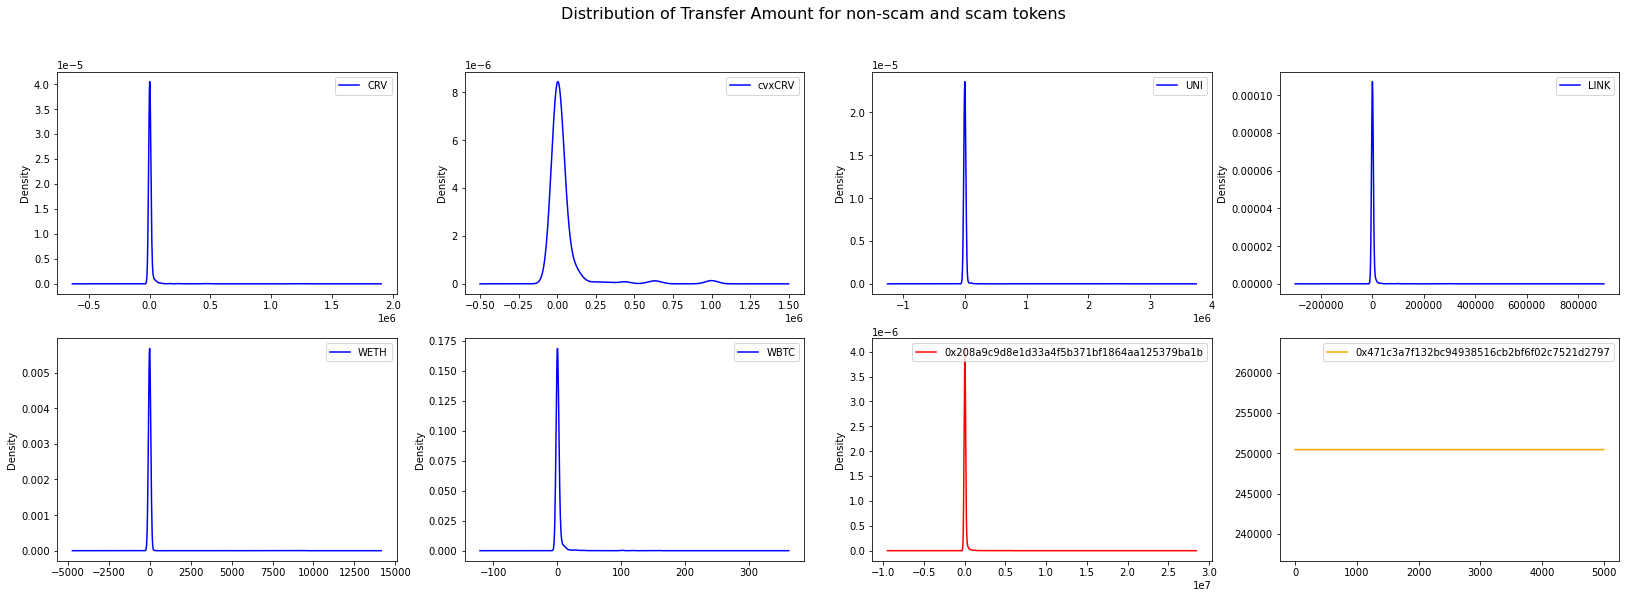

1 5000 0 5001


In [42]:
fig, axes = plt.subplots(2, 4, figsize=(28,9))
axes = axes.ravel()
for _fig_n,(df,label) in enumerate(zip(
    [df_crv, df_cvx_crv, df_uni, df_link, df_weth, df_wbtc, df_s2],
    ['CRV', 'cvxCRV', 'UNI', 'LINK', 'WETH', 'WBTC', token_s2.address])):

    if _fig_n == 6:
        line = df.value.plot.density(label=label, ax=axes[_fig_n], color='red')
    else:
        line = df.value.plot.density(label=label, ax=axes[_fig_n], color='blue')
    axes[_fig_n].legend()
    
    s_from, s_to = set(df.from_address.unique()), set(df.to_address.unique())

    print(
        df.from_address.unique().shape[0],
        df.to_address.unique().shape[0], 
        len(s_from & s_to),
        len(s_from | s_to - s_from & s_to),
    )
    
    # plt.xlim((-0.1e6, 0.2e6))
    # plt.title(label=f'Distribution of Transfer amount for {label}')
    # plt.legend()
    # plt.show()

df_s1.value.plot(label=token_s1.address, ax=axes[-1], color='orange')
axes[-1].legend()

fig.suptitle('Distribution of Transfer Amount for non-scam and scam tokens', fontsize=16)
plt.show()

s_from, s_to = set(df_s1.from_address.unique()), set(df_s1.to_address.unique())

print(
    df_s1.from_address.unique().shape[0],
    df_s1.to_address.unique().shape[0], 
    len(s_from & s_to),
    len(s_from | s_to - s_from & s_to),
)


In [21]:
token_ve_crv.abi.events

Events: [CommitOwnership, ApplyOwnership, Deposit, Withdraw, Supply]

In [25]:
df_ve_crv_deposit = pd.DataFrame(token_ve_crv.fetch_events(
    token_ve_crv.events.Deposit,
    from_block=one_day_earlier_block
))

df_ve_crv_supply = pd.DataFrame(token_ve_crv.fetch_events(
    token_ve_crv.events.Supply,
    from_block=one_day_earlier_block
))

display(df_ve_crv_deposit)
display(df_ve_crv_supply)

,args,event,logIndex,transactionIndex,transactionHash,address,blockHash,blockNumber,provider,locktime,value,type,ts
0,"(provider, locktime, value, type, ts)",Deposit,143,93,b'\x973{\x82\x1d}\x11\x97\xff\xeaR5\x037\xbc\x...,0x5f3b5DfEb7B28CDbD7FAba78963EE202a494e2A2,b'\x1d\x82\x96\xf4\xf2O\x91\x01>\xe2\xcf\xc4\x...,16525883,0x51A7EaD10340AF963C3124b026b86dd2807c2b1C,1801094400,0,3,1675156967
1,"(provider, locktime, value, type, ts)",Deposit,234,108,b'\xc44\xd9d^Z)\x90\xf1n\x8c\\\x19\xf2\xbeP\x9...,0x5f3b5DfEb7B28CDbD7FAba78963EE202a494e2A2,b'\x13?\xf7\x04!\x86eG\x1c/\xb2\x86O\x1fKV5\xf...,16527362,0xb36a0671B3D49587236d7833B01E79798175875f,1801094400,0,3,1675174823
2,"(provider, locktime, value, type, ts)",Deposit,318,151,b'\xc0D\xcdHLE|\xa4\xefl\x12\xda\xccx\x00\x84\...,0x5f3b5DfEb7B28CDbD7FAba78963EE202a494e2A2,b'%\x94O[E\x19\xc0\x11\x05\xcd\x01.\xbd\xcfoY\...,16527621,0x989AEb4d175e16225E39E87d0D97A3360524AD80,1800489600,21796799750292740912672,2,1675177931
3,"(provider, locktime, value, type, ts)",Deposit,246,137,b'\xe2+\x93\xd8:\xd3\xa7/\xf9\xaa\xc3\xfc\xe2u...,0x5f3b5DfEb7B28CDbD7FAba78963EE202a494e2A2,b'\xb3\xc5O\xa5<\xf4{K\xeb\xf2{k\x9b\xbc\xc6\x...,16527839,0xC90CDF28Ff59e955b1256ee5224cAc60B0c9D77D,1706140800,1200000000000000000000,1,1675180547
4,"(provider, locktime, value, type, ts)",Deposit,14,3,b'o\x89\x15\xe9\x00\xbcLP\xb2\xcaBT\xbe6\x95@r...,0x5f3b5DfEb7B28CDbD7FAba78963EE202a494e2A2,b'\xef7\xfb\x8f@\x87\xf8\xcd\x93\x94\xcd\x98rE...,16530297,0x195f357e4C3e015c3ad5aE9f47Da2c144F074E2c,1801094400,10000000000000000000,1,1675210199
5,"(provider, locktime, value, type, ts)",Deposit,225,108,b'gC\x9d\x8c\x813x\x16oxo\xc2\xd6N\xc1V\x94g\x...,0x5f3b5DfEb7B28CDbD7FAba78963EE202a494e2A2,b'[Q\xff<y8\xb8\xf2\xe2\xf0\xf1_\x94\xc8\xfc\x...,16530417,0xD1A0B66835D830e9ada42eEf436f3AA8005b20B5,1801094400,0,3,1675211639
6,"(provider, locktime, value, type, ts)",Deposit,419,104,b'R\xb0\xb0z4E^\x0e\xabH\x9e\xaa\xad\\\xae\xdb...,0x5f3b5DfEb7B28CDbD7FAba78963EE202a494e2A2,b'\x8bFL(aG\xd4\xac(Y\x11\x12\xc4z\xb0\x8c\x14...,16531413,0x2f2e6EB29E813f8E8B296f9d021033d5f4DEdDD6,1801094400,3850019302000000000000,1,1675223639
7,"(provider, locktime, value, type, ts)",Deposit,875,109,b'\xbe#\n\x89\x17\xde\x9b\xafG\xeexlu\x958R\x8...,0x5f3b5DfEb7B28CDbD7FAba78963EE202a494e2A2,b'\x1f$+N\xf3iA0\x7f\xec\x9cGQ\xce\x9a\x07\\+J...,16531963,0x708E5804D0e930Fac266d8B3F3e13EdbA35ac86E,1801094400,0,3,1675230299
8,"(provider, locktime, value, type, ts)",Deposit,161,105,"b'\xd2\xd0\xf6I\x01{X/\xd1,\x10T\x88\xeed\xd4\...",0x5f3b5DfEb7B28CDbD7FAba78963EE202a494e2A2,b'e\n\xd2\xe8\x9b\x8a\xdc:\xa6||\xdb\xa5\x80\x...,16532580,0xcf9BF539AF5e40e536286fE2e8CbA390C6C14044,1801094400,27000000000000000000,1,1675237727
9,"(provider, locktime, value, type, ts)",Deposit,198,94,b'\xd6\x19\xe2\xeaa\xb3\x1e\xc1}\x86\x97\xc1\x...,0x5f3b5DfEb7B28CDbD7FAba78963EE202a494e2A2,"b""g\x17\x84\xd29\x9fj.\xe7\xee\x8e\xf5\x07\x12...",16532586,0x2536E88B369947D1c02aB3A2bb36150296578953,1706745600,20000000000000000000,1,1675237799


,args,event,logIndex,transactionIndex,transactionHash,address,blockHash,blockNumber,prevSupply,supply
0,"(prevSupply, supply)",Supply,144,93,b'\x973{\x82\x1d}\x11\x97\xff\xeaR5\x037\xbc\x...,0x5f3b5DfEb7B28CDbD7FAba78963EE202a494e2A2,b'\x1d\x82\x96\xf4\xf2O\x91\x01>\xe2\xcf\xc4\x...,16525883,634996339054410461314361742,634996339054410461314361742
1,"(prevSupply, supply)",Supply,235,108,b'\xc44\xd9d^Z)\x90\xf1n\x8c\\\x19\xf2\xbeP\x9...,0x5f3b5DfEb7B28CDbD7FAba78963EE202a494e2A2,b'\x13?\xf7\x04!\x86eG\x1c/\xb2\x86O\x1fKV5\xf...,16527362,634996339054410461314361742,634996339054410461314361742
2,"(prevSupply, supply)",Supply,319,151,b'\xc0D\xcdHLE|\xa4\xefl\x12\xda\xccx\x00\x84\...,0x5f3b5DfEb7B28CDbD7FAba78963EE202a494e2A2,b'%\x94O[E\x19\xc0\x11\x05\xcd\x01.\xbd\xcfoY\...,16527621,634996339054410461314361742,635018135854160754055274414
3,"(prevSupply, supply)",Supply,247,137,b'\xe2+\x93\xd8:\xd3\xa7/\xf9\xaa\xc3\xfc\xe2u...,0x5f3b5DfEb7B28CDbD7FAba78963EE202a494e2A2,b'\xb3\xc5O\xa5<\xf4{K\xeb\xf2{k\x9b\xbc\xc6\x...,16527839,635018135854160754055274414,635019335854160754055274414
4,"(prevSupply, supply)",Supply,15,3,b'o\x89\x15\xe9\x00\xbcLP\xb2\xcaBT\xbe6\x95@r...,0x5f3b5DfEb7B28CDbD7FAba78963EE202a494e2A2,b'\xef7\xfb\x8f@\x87\xf8\xcd\x93\x94\xcd\x98rE...,16530297,635019335854160754055274414,635019345854160754055274414
5,"(prevSupply, supply)",Supply,226,108,b'gC\x9d\x8c\x813x\x16oxo\xc2\xd6N\xc1V\x94g\x...,0x5f3b5DfEb7B28CDbD7FAba78963EE202a494e2A2,b'[Q\xff<y8\xb8\xf2\xe2\xf0\xf1_\x94\xc8\xfc\x...,16530417,635019345854160754055274414,635019345854160754055274414
6,"(prevSupply, supply)",Supply,420,104,b'R\xb0\xb0z4E^\x0e\xabH\x9e\xaa\xad\\\xae\xdb...,0x5f3b5DfEb7B28CDbD7FAba78963EE202a494e2A2,b'\x8bFL(aG\xd4\xac(Y\x11\x12\xc4z\xb0\x8c\x14...,16531413,635019345854160754055274414,635023195873462754055274414
7,"(prevSupply, supply)",Supply,876,109,b'\xbe#\n\x89\x17\xde\x9b\xafG\xeexlu\x958R\x8...,0x5f3b5DfEb7B28CDbD7FAba78963EE202a494e2A2,b'\x1f$+N\xf3iA0\x7f\xec\x9cGQ\xce\x9a\x07\\+J...,16531963,635023195873462754055274414,635023195873462754055274414
8,"(prevSupply, supply)",Supply,162,105,"b'\xd2\xd0\xf6I\x01{X/\xd1,\x10T\x88\xeed\xd4\...",0x5f3b5DfEb7B28CDbD7FAba78963EE202a494e2A2,b'e\n\xd2\xe8\x9b\x8a\xdc:\xa6||\xdb\xa5\x80\x...,16532580,635023195873462754055274414,635023222873462754055274414
9,"(prevSupply, supply)",Supply,199,94,b'\xd6\x19\xe2\xeaa\xb3\x1e\xc1}\x86\x97\xc1\x...,0x5f3b5DfEb7B28CDbD7FAba78963EE202a494e2A2,"b""g\x17\x84\xd29\x9fj.\xe7\xee\x8e\xf5\x07\x12...",16532586,635023222873462754055274414,635023242873462754055274414
